### ***Twitter Semantic Analysis of Oscar Nominees For Best Picture (Feb 2023)***

This notebook contains a project during my graduate studies that we were tasked to collect twitter data from 
three different categories and perform opinion mining. Due to the fact that this project took place in February 2023, 
three movies that were running for best picture for the Oscars were chosen. In particular, the movies were All quiet 
on the western front, Avatar the way of water and Top gun maverick were selected. The tweets were collected using 
twitter's API V1 leveraging the tweepy python library. Furthermore, the tweets collection process took place between 
February 11-13 as well as February 20-22. Due to the limitation that the twitter API had, I collected tweets that 
were only posted seven days prior the previously mentioned dates. Lastly, at that time period, the twitter API became 
subscription based and there were more limitation to the tweet data that I could collect. Nonetheless, 2969 tweets were
collected all in all and then analyzed. The tweets were collected in batches and stored in .csv files and a MySQL database.

In [1]:
import mysql.connector
from mysql.connector import errorcode
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.graph_objects as go
from IPython.display import Image

In [ ]:
#tweet extraction code block 
#beater token to access twitter API v1 endpoints.
bearer_token = 'add token here'
client = tweepy.Client(bearer_token=bearer_token,wait_on_rate_limit=True)

#hashtags used
#TopGunMaverick
#AvatarTheWayOfWater
#AllQuietOnTheWesternFront
#use paginator to get more that 100 tweets.
keyword = "#AvatarTheWayOfWater -is:retweet lang:en " #excludes retweets and english language tweets are only extracted
tweets = tweepy.Paginator(client.search_recent_tweets, query=keyword,
                              tweet_fields=['context_annotations', 'created_at',"author_id","source","geo","public_metrics"],
                              user_fields=['public_metrics'],expansions='geo.place_id',
                              place_fields=['place_type', 'geo']).flatten(limit=1000)

followers = []
usernames = []
n_of_tweets = []
tweet_text = []
retweets= []
date_of_tweet = []



for tweet in tweets: 
    #number of followers of account
    follows = client.get_users_followers(id=tweet.author_id,user_fields=['public_metrics'],max_results=1000).meta['result_count']         
    followers.append(follows)
    
    #username of person
    username = '@' + client.get_user(id=tweet.author_id,user_fields=['public_metrics','location'])[0].username
    usernames.append(username)
    
    #text of tweet
    tweet_text.append(tweet.text)
    
    #number of retweets
    n_of_retweets= client.get_retweeters(id=tweet.id).meta["result_count"]
    retweets.append(n_of_retweets)
    
    #number of user_tweets
    n_of_tweets.append(client.get_users_tweets(id=tweet.author_id,max_results=100).meta['result_count'])
    
    #date of tweet
    date_of_tweet.append(tweet.created_at)
    

    
    
#### The codes below where executed once a batch of tweets was collected for each case. We stored the extracted tweets in csv files.
#Maverick = pd.DataFrame(list(zip(usernames,tweet_text,followers,n_of_tweets,retweets,date_of_tweet)))
#Maverick.to_csv('Maverick2.csv')

#Avatar = pd.DataFrame(list(zip(usernames,tweet_text,followers,n_of_tweets,retweets,date_of_tweet)))
#Avatar.to_csv('Avatar2.csv')

#west = pd.DataFrame(list(zip(usernames,tweet_text,followers,n_of_tweets,retweets,date_of_tweet)))
#west.to_csv('WesternFront2.csv')

In [ ]:
#code block to store pandas dataframe in MySQL database.
def store_tweets(dataframe):
    
    try:
        db = mysql.connector.connect(host='localhost', database='twitteranalysis', user='user',
                                     password='enter pass')
        if db.is_connected():
            print("CONNECTED TO MYSQL DATABASE!")
            cur = db.cursor()
            
            #insert query to tweedb table.NULL value refers to tweet's location.
            q = '''INSERT INTO tweetdb VALUES(%s,%s,%s,%s,%s,%s,%s,NULL,%s,%s)'''
            
            #convert each row of dataframe to a tuple withou keeping indexes of dataframe
            data_sql = list(dataframe[['username', 'tweet_text', 'followers', 'number_of_tweets', 'retweets',
                                    'date', 'hashtags', 'polarity', 'sentiment']].itertuples(index=False, name=None))
            #execute query
            cur.executemany(q,data_sql)
            db.commit()
            
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        db.close()

#store each pandas dataframe to MySQL workbench table
store_tweets(avatar)
store_tweets(maverick)
store_tweets(westfront)
#process executed successfully

For every movie 2 batches of tweets were collected and the stored. 
The tweet collection process can be visualized by the following sankey diagram

In [ ]:
#sankey graph for tweet collection 
#Define input and output flows

labels = ['Avatar batch 1', 'Avatar batch 2', 'Maverick batch 1', 'Maverick batch 2','Westfront batch 1',
          'westfront batch 2','Avatar final(removed dups)', 'Maverick Final(removed dups)', 'Western Front final(removed dups)','All tweets']

#map connections
first_layer = [0, 1, 2, 3, 4, 5,6,7,8]
target = [6, 6, 7,7,8,8,9,9,9]
 
#percentages that control size of flows in links
value = [0.5,0.5,0.5,0.5,0.5,0.5,1,1,1]

colors = ['blue','blue','green','green','red','red','blue','green','red','orange']

node_values = [1000,1000,629,561,342,705,822,950,924,2696]

trace = go.Sankey(node=dict(
            pad=15,
            thickness=20,
            label=[f'{label} ({value})' for label, value in zip(labels, node_values)], #match labels with number of tweets
            color=colors,
            hovertemplate='%{label}<br>Value: %{customdata:.0f}<extra></extra>', #add template
            customdata=node_values),
            link=dict(source=first_layer, target=target, value=value))


figure = go.Figure(data=trace)
figure.update_layout(title_text="Tweet collection process")

#store sankey diagram to .html file
figure.write_html("sankey.html")
figure.show()


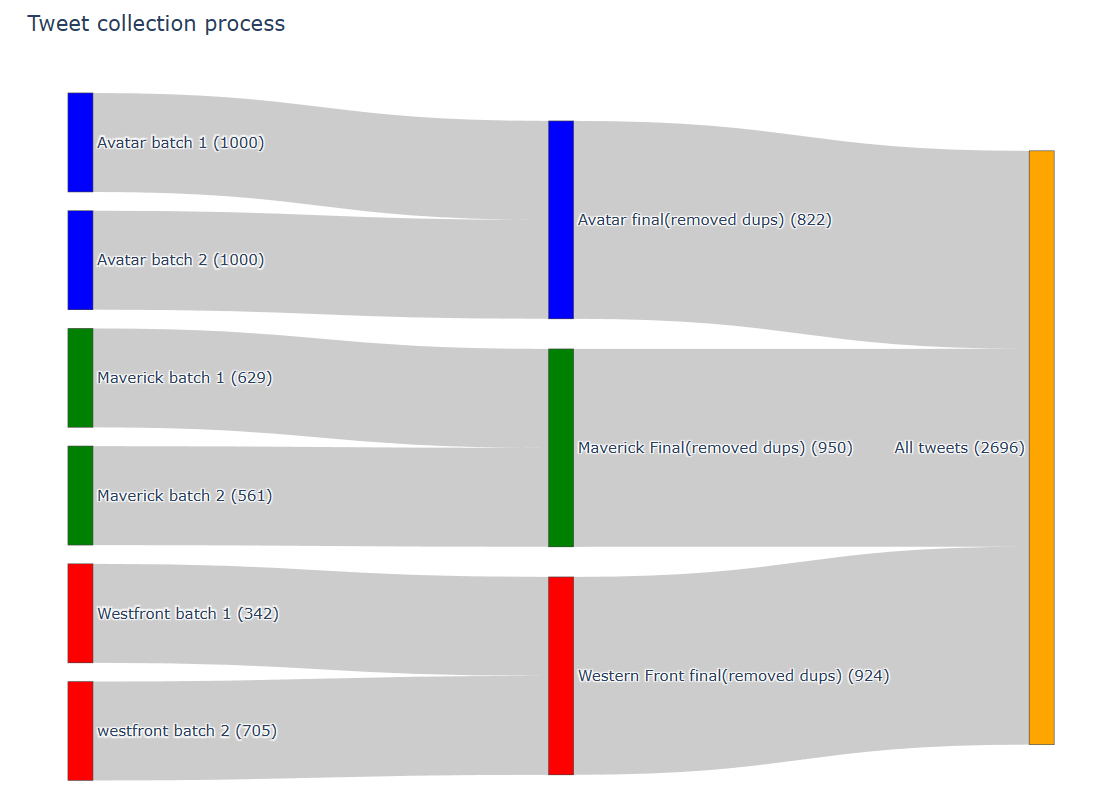

In [2]:
Image("sankey.png")

### ***Load  And Clean Tweet Data***

In [3]:
#function to clean text data 
def clean_tweets(x,movie):
    #remove spam tweets from users
    cleaned_data = x.drop_duplicates(subset=['username','tweet_text'])
    
    #extract hashtags from tweets
    text = cleaned_data['tweet_text']
    hashtags = []
    for i in text:
        hashtags.append(' '.join(re.findall(r"#(\w+)", i)))
    cleaned_data['hashtags'] = hashtags
    
    #remove urls mentions and hashtags from tweets.
    for i in cleaned_data.index.to_series():
        cleaned_data.loc[i,'tweet_text'] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(http\S+)"," ",cleaned_data.loc[i,'tweet_text']).split())
    
    #After reviewing tweets we get rid of a users that spams tweets in each movie.
    if movie == "avatar":
        cleaned_data = cleaned_data[cleaned_data['username'] != '@AvatarInFrame']
    if movie == 'maverick':
        cleaned_data = cleaned_data[cleaned_data['username'] != '@Bengiamino']
        cleaned_data = cleaned_data[cleaned_data['username'] != '@PawsUp_Taiwan']
    if movie == 'westernfront':
        cleaned_data = cleaned_data[cleaned_data['username'] != '@Bengiamino']
        cleaned_data = cleaned_data[cleaned_data['username'] != '@KeemigsMovies']
        cleaned_data = cleaned_data[cleaned_data['username'] != '@KrissBaileyWeb3']
    return cleaned_data

**Avatar The Way Of Water**

In [4]:
#load 1rst batch of avatar tweets and clean them
data = pd.read_csv('Avatar.csv',encoding='unicode_escape',engine='python')
clean_avatar = clean_tweets(data,'avatar')

#load 2nd batch of avatar tweets and clean them
data2a = pd.read_csv('Avatar2.csv',encoding='unicode_escape',engine='python')
clean_avatar2 = clean_tweets(data2a,'avatar')

#merge the batches into one dataframe
data_avatar_concat = pd.concat([clean_avatar,clean_avatar2],axis = 0)

#finaly remove duplicate tweets from batches after cleaning.A user might spam tweets for many weeks etc so we must remove duplicates again..
data_avatar = data_avatar_concat.drop_duplicates(subset=['username','tweet_text'])

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags
C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags


**Top Gun Maverick**

In [6]:
#load 1rst batch of maverick tweets and clean them
data2 = pd.read_csv('Maverick.csv',encoding='unicode_escape',engine='python')
clean_mav = clean_tweets(data2,'maverick')

#load 2nd batch of maverick tweets and clean them
data2m = pd.read_csv('Maverick2.csv',encoding='unicode_escape',engine='python')
clean_mav2 = clean_tweets(data2m,'maverick')

#merge the batches into one dataframe
data_mav_concat = pd.concat([clean_mav,clean_mav2],axis = 0)

#finaly remove duplicate tweets from batches after cleaning.A user might spam tweets for many weeks etc so we must remove duplicates again..
data_mav = data_mav_concat.drop_duplicates(subset=['username','tweet_text'])

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags
C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags


**All Quiet On The Western Front**

In [5]:
#load 1rst batch of all quite on the western front tweets and clean them
data3 = pd.read_csv('WesternFront.csv',encoding='unicode_escape',engine='python')
clean_west = clean_tweets(data3,'westernfront')

#load 2nd batch of all quite on the western front tweets and clean them
data4 = pd.read_csv('WesternFront2.csv',encoding='unicode_escape',engine='python')
clean_west2 = clean_tweets(data4,'westernfront')

#merge the batches into one dataframe
data_west_concat = pd.concat([clean_west,clean_west2],axis = 0)

#finaly remove duplicate tweets from batches after cleaning.A user might spam tweets for many weeks etc so we must remove duplicates again.
data_west = data_west_concat.drop_duplicates(subset=['username','tweet_text'])

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags
C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3715328092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['hashtags'] = hashtags


### ***Sentiment Analysis***

In [7]:
#find sentiment
def sentiment(data):
    dataframe = data
    polarity= []
    sentiment = []
    #find porality and sentiment of cleaned tweets and store the results in the dataframe of each movie
    for i in range(dataframe.shape[0]):
        analysis = TextBlob(dataframe.iloc[i,1])
        polarity.append(analysis.sentiment.polarity)
        if analysis.sentiment.polarity > 0:
            sentiment.append('Positive')
        elif analysis.sentiment.polarity <0:
            sentiment.append('Negative')
        else:
            sentiment.append('Neutral')
    dataframe['polarity'] = polarity
    dataframe['sentiment'] = sentiment
    return dataframe

#final dataframes for each movie where they will be used for graphs/analysis.
westfront = sentiment(data_west)
maverick = sentiment(data_mav)
avatar = sentiment(data_avatar)

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\385280517.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['polarity'] = polarity
C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\385280517.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['sentiment'] = sentiment
C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\385280517.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [8]:
avatar.head()

,username,tweet_text,followers,number_of_tweets,retweets,date,hashtags,polarity,sentiment
1,@AshokOfficial_,Top Nett Box Office Movies India Including All...,1000,100,0,2023-02-12 02:14:21+00:00,2Point0 AvatarTheWayOfWaterï Dangal AvengersEn...,0.500000,Positive
3,@flamesoffury14,Finally got to see Avatar the way of water If ...,33,100,0,2023-02-12 02:08:30+00:00,AvatarTheWayOfWater,0.260000,Positive
4,@chrisilcox,AvatarTheWayOfWater is the 3rd highest grossin...,1000,99,0,2023-02-12 02:06:02+00:00,AvatarTheWayOfWater JennStafford TaunuiTsahik ...,0.114583,Positive
6,@MannyPeezy,Loving the dread lock on AvatarTheWayOfWater,125,100,0,2023-02-12 02:03:03+00:00,AvatarTheWayOfWater,0.600000,Positive
7,@liooxn_n_2,Idk why but I like this sketch with such abstr...,108,100,0,2023-02-12 02:02:43+00:00,NETEYAM AvatarTheWayOfWater,0.000000,Neutral


In [9]:
#percentage of sentiment in each case
print('westfront tweet sentiment')
print(westfront['sentiment'].value_counts()/westfront.shape[0] *100)
print('\n')
print('Top gun maverick tweet sentiment')
print(maverick['sentiment'].value_counts()/maverick.shape[0] *100)
print('\n')
print('Avatar the way of water tweet sentiment')
print(avatar['sentiment'].value_counts()/avatar.shape[0] *100)
print('\n')

westfront tweet sentiment
Positive    65.334773
Neutral     23.866091
Negative    10.799136
Name: sentiment, dtype: float64


Top gun maverick tweet sentiment
Positive    60.906217
Neutral     31.190727
Negative     7.903056
Name: sentiment, dtype: float64


Avatar the way of water tweet sentiment
Positive    47.445255
Neutral     43.187348
Negative     9.367397
Name: sentiment, dtype: float64




From the sentiment table we notice that people in general have a positive sentiment in the 
Top Gun Maverick and All Quiet On The Western Front movie(>60% positive sentiment). On the 
other hand, we can see that in Avatar The Way Of water case, nearly 40% of tweets have a neutral 
sentiment. After reviewing our tweets, this observation might be linked to people posting tweets 
about fanart of certain characters of the movie and generally neutral information about the movie’s 
characters/universe.

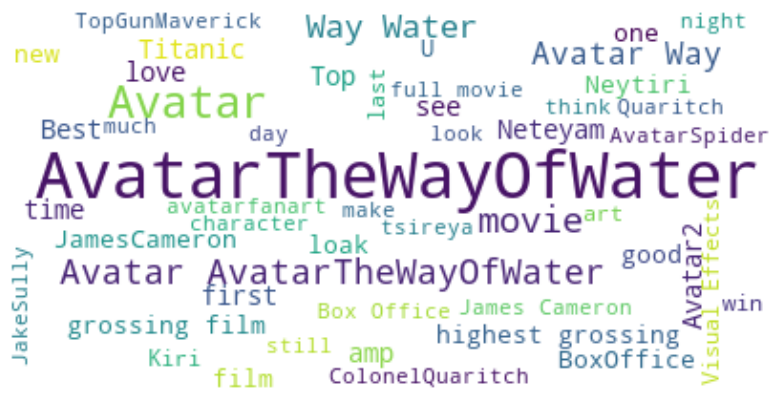

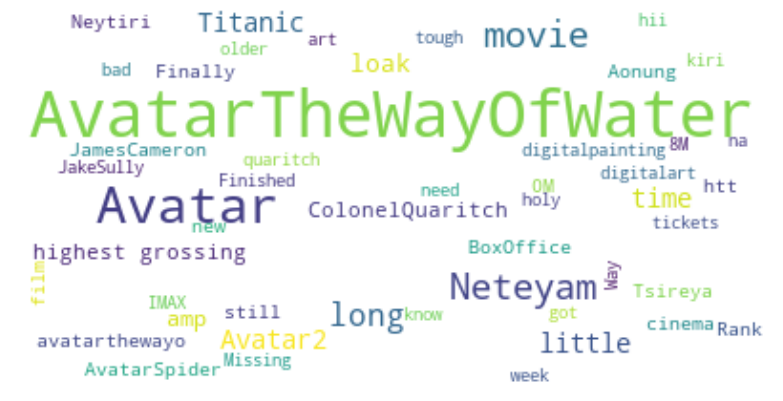

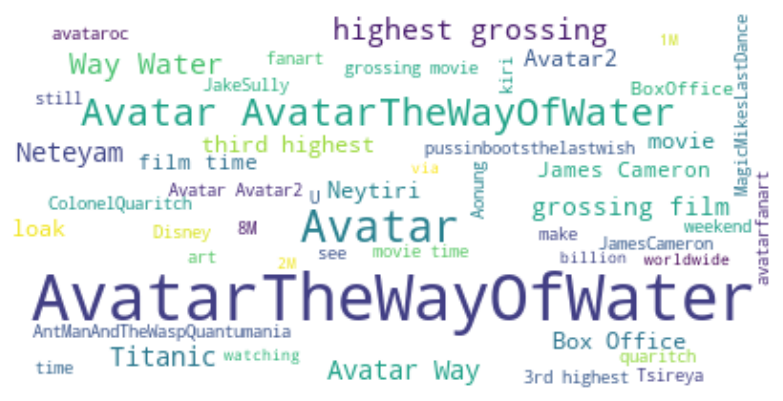

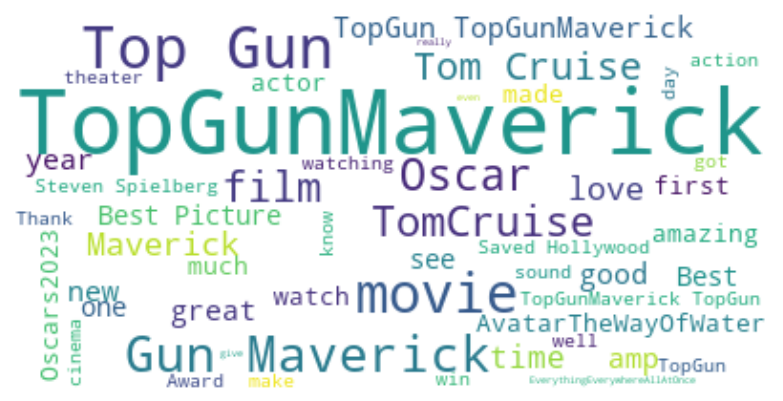

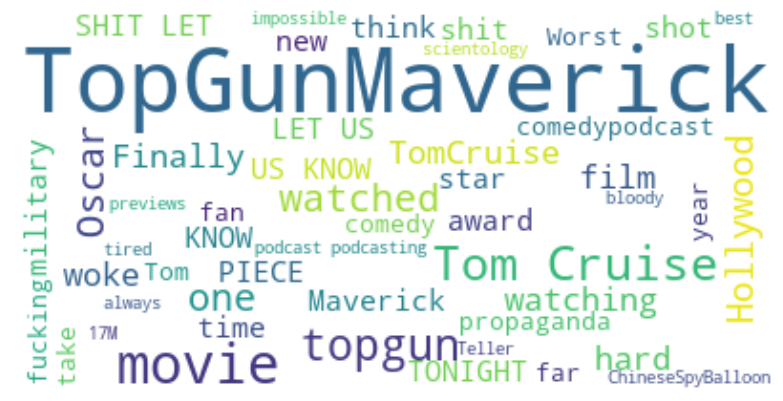

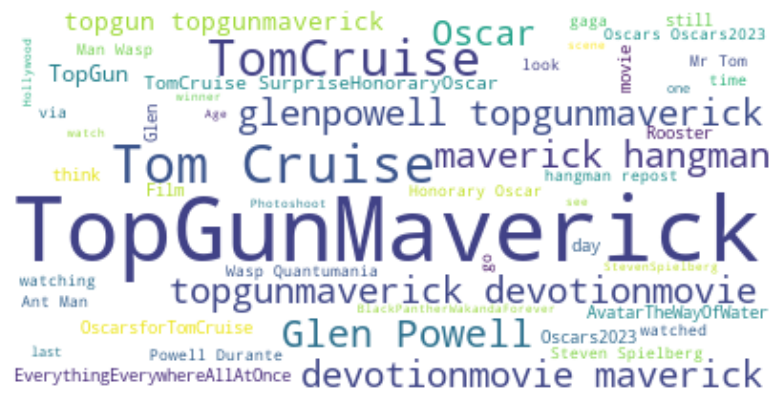

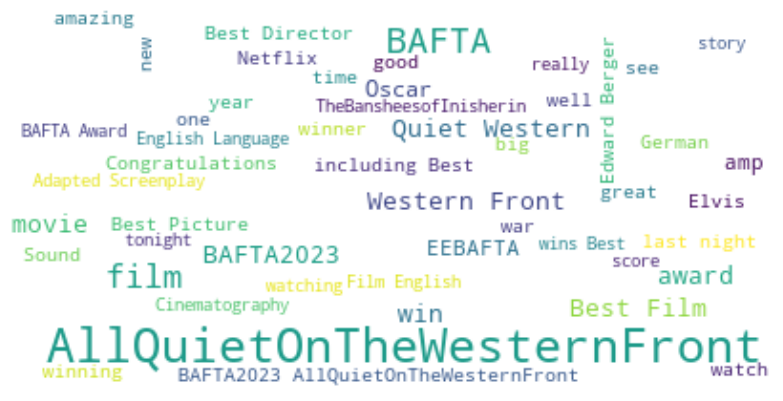

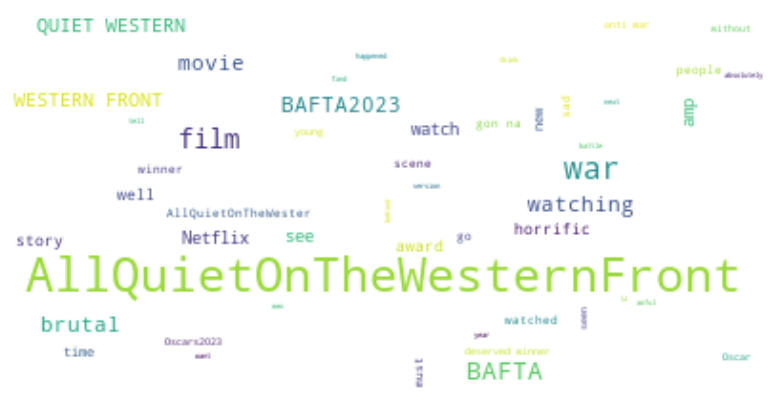

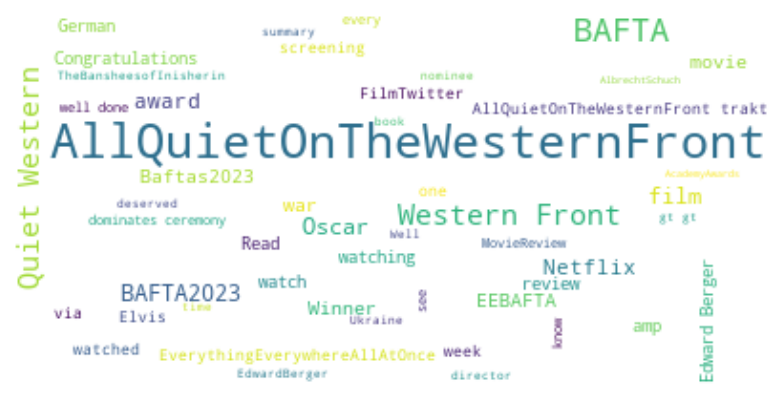

In [10]:
#function to split data set into positive,negative and neutral sentiment.
def split_sentiment(dataframe):
    positive_dataframe = dataframe[dataframe['polarity'] > 0]
    negative_dataframe = dataframe[dataframe['polarity'] <0]
    neutral_dataframe = dataframe[dataframe['polarity'] == 0]
    return positive_dataframe, negative_dataframe, neutral_dataframe


#function to create wordcloud in for each sentiment in each movie.
def create_wordcloud(dataframe):
    #create a string with all the tweets in each movie
    text = " ".join(tweet for tweet in dataframe['tweet_text'])
    
    #load stopwords
    stop_words = set(stopwords.words('english'))
    
    #tokenize words
    word_tokens = word_tokenize(text)
    
    #remove stopwords
    cleaned_text = ' '.join([w for w in word_tokens if not w.lower() in stop_words])
    
    #create wordcloud
    wordcloud = WordCloud(max_font_size=50, max_words=50,background_color="white").generate(cleaned_text)
    plt.figure(figsize = (8,8),dpi=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    
pos_avatar, neg_avatar, neut_avatar = split_sentiment(avatar)
pos_maverick, neg_maverick, neut_maverick = split_sentiment(maverick)
pos_westfront, neg_westfront, neut_westfront = split_sentiment(westfront)

#avatar wordclouds
create_wordcloud(pos_avatar)
create_wordcloud(neg_avatar)
create_wordcloud(neut_avatar)
#maverick wordclouds
create_wordcloud(pos_maverick)
create_wordcloud(neg_maverick)
create_wordcloud(neut_maverick)
#westfront wordclouds
create_wordcloud(pos_westfront)
create_wordcloud(neg_westfront)
create_wordcloud(neut_westfront)

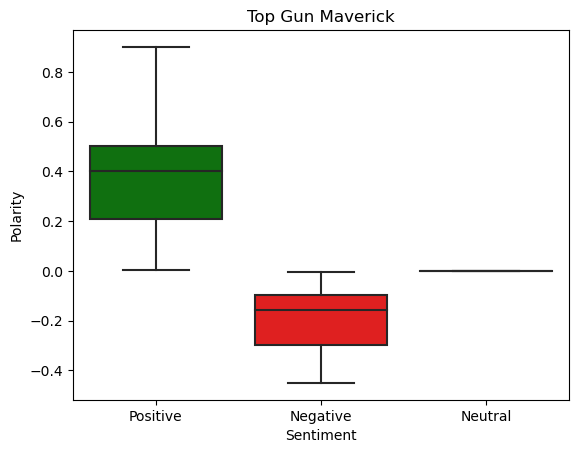

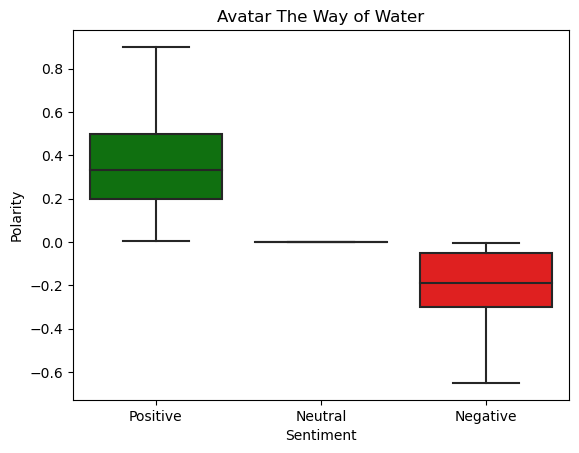

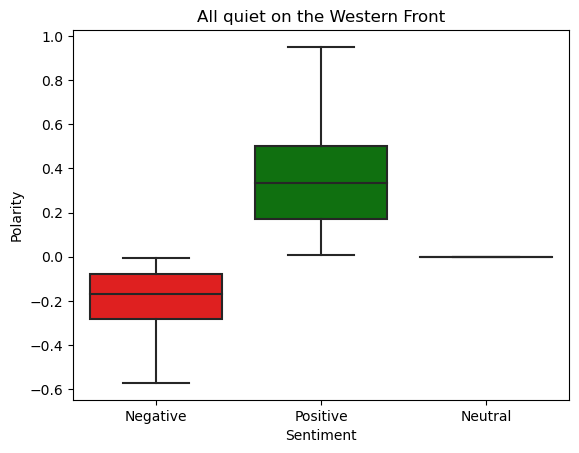

In [11]:
#create seaborn boxplots by group. We excluded outliers from each boxplot
def sentiment_boxes(dataframe,movie):
    color = {"Positive": "g", "Negative": "r", "Neutral":"m"}
    if movie == 'avatar':
        sns.boxplot(x='sentiment', y='polarity',
                data=dataframe, showfliers=False,palette=color)
        plt.title('Avatar The Way of Water')
        plt.xlabel('Sentiment')
        plt.ylabel('Polarity')
        plt.show()
    elif movie == 'maverick':
        sns.boxplot(x='sentiment', y='polarity',
                data=dataframe, showfliers=False,palette=color)
        plt.title('Top Gun Maverick')
        plt.xlabel('Sentiment')
        plt.ylabel('Polarity')
        plt.show()
    elif movie == 'westfront':
        sns.boxplot(x='sentiment', y='polarity',
                data=dataframe, showfliers=False,palette=color)
        plt.title('All quiet on the Western Front')
        plt.xlabel('Sentiment')
        plt.ylabel('Polarity')
        plt.show()
        
sentiment_boxes(maverick,'maverick')
sentiment_boxes(avatar,'avatar')
sentiment_boxes(westfront,'westfront')

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3126962637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = date


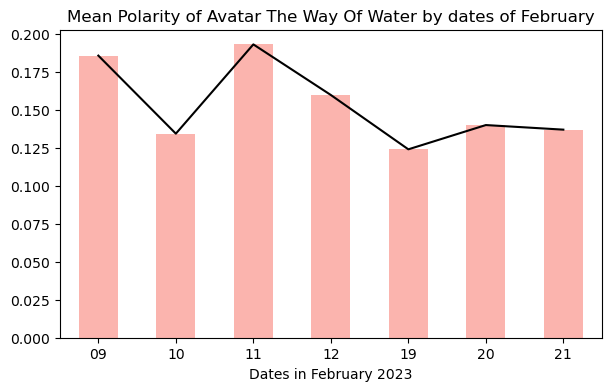

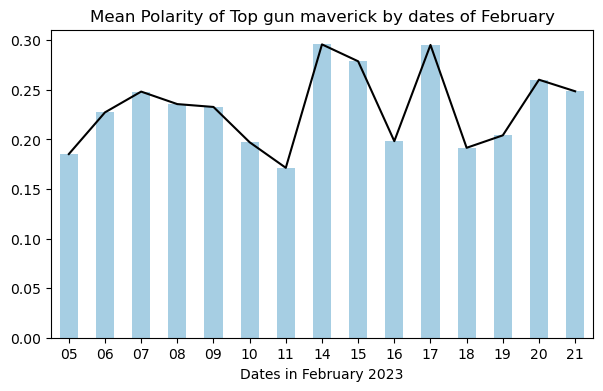

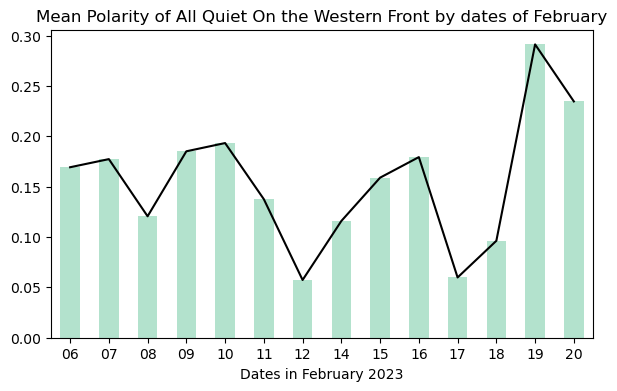

In [12]:
#function to isolate the day of each date in february
def get_day(dataframe):
    date = []
    for i in list(dataframe['date']):
        date.append(i[8:10])

    dataframe['date'] = date
    return dataframe

avatar = get_day(avatar)
maverick = get_day(maverick)
westfront = get_day(westfront)

#create mean of polarities in each case by days of the month February when tweets where posted.
#Avatar the way of water.
datafgraph = avatar.groupby(['date'])['polarity'].mean() #group by polarity and date
datafgraph.plot(kind='bar', title='Mean Polarity of Avatar The Way Of Water by dates of February',colormap='Pastel1',figsize=(7, 4))
datafgraph.plot(kind='line', color='black')
plt.xlim(-0.5,6.5) #center the barchart better
plt.xlabel('Dates in February 2023')
plt.show()

#Top gun Maverick
datafgraph = maverick.groupby(['date'])['polarity'].mean()
datafgraph.plot(kind='bar', title='Mean Polarity of Top gun maverick by dates of February',colormap='Paired',figsize=(7, 4))
datafgraph.plot(kind='line', color='black')
plt.xlim(-0.5,14.5) #center the barchart better
plt.xlabel('Dates in February 2023')
plt.show()


#All quiet on the western front
datafgraph = westfront.groupby(['date'])['polarity'].mean()
datafgraph.plot(kind='bar', title='Mean Polarity of All Quiet On the Western Front by dates of February',colormap = 'Pastel2', figsize=(7, 4))
datafgraph.plot(kind='line', color='black')
plt.xlim(-0.5,13.5) #center the barchart better
plt.xlabel('Dates in February 2023')
plt.show()

C:\Users\johnp\AppData\Local\Temp\ipykernel_11168\3126962637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = date


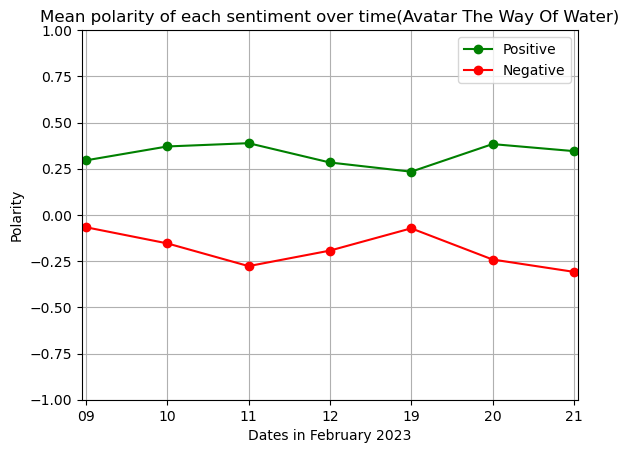

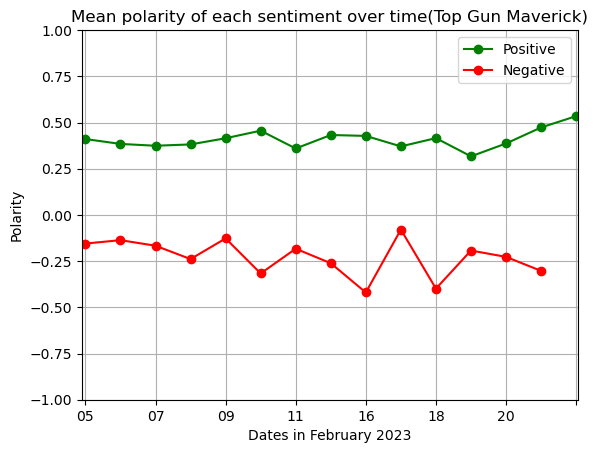

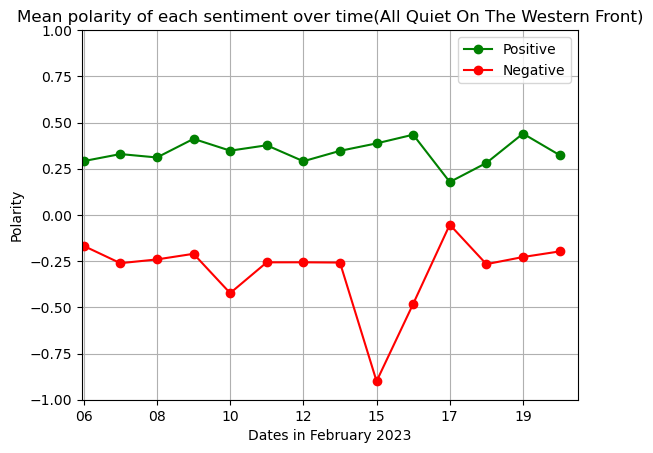

In [13]:
# get days for positive/negative sentiment in each movie
pos_avatar = get_day(pos_avatar)
neg_avatar = get_day(neg_avatar)


pos_maverick = get_day(pos_maverick)
neg_mavrick = get_day(neg_maverick)


pos_westfront = get_day(pos_westfront)
neg_westfront = get_day(neg_westfront)


#avatar
datagraph = pos_avatar.groupby(['date'])['polarity'].mean() #group by polarity and date
datagraph.plot(kind= 'line',color='g',marker='o',grid=True)
datagraph2 = neg_avatar.groupby(['date'])['polarity'].mean()
datagraph2.plot(kind= 'line',color='r',marker = 'o',grid=True)
plt.ylim(-1,1)
plt.xlim(-0.05,6.05)
plt.legend(['Positive','Negative'])
plt.title('Mean polarity of each sentiment over time(Avatar The Way Of Water)')
plt.xlabel('Dates in February 2023')

plt.ylabel('Polarity')
plt.show()

#maverick
datagraph = pos_maverick.groupby(['date'])['polarity'].mean()
datagraph.plot(kind= 'line',color='g',marker='o',grid=True)
datagraph2 = neg_maverick.groupby(['date'])['polarity'].mean()
datagraph2.plot(kind= 'line',color='r',marker = 'o',grid=True)
plt.ylim(-1,1)
plt.xlim(-0.1,14.05)
plt.legend(['Positive','Negative'])
plt.title('Mean polarity of each sentiment over time(Top Gun Maverick)')
plt.xlabel('Dates in February 2023')

plt.ylabel('Polarity')
plt.show()


#All quiet on the western front
datagraph = pos_westfront.groupby(['date'])['polarity'].mean()
datagraph.plot(kind= 'line',color='g',marker='o',grid=True)
datagraph2 = neg_westfront.groupby(['date'])['polarity'].mean()
datagraph2.plot(kind= 'line',color='r',marker = 'o',grid=True)
plt.ylim(-1,1)
plt.xlim(-0.05,13.5)
plt.legend(['Positive','Negative'])
plt.title('Mean polarity of each sentiment over time(All Quiet On The Western Front)')
plt.xlabel('Dates in February 2023')

plt.ylabel('Polarity')
plt.show()

For all three movies, the mean 
polarity has ups and downs across the dates of February 6
th and February 21st, with All Quiet in 
the Western Front showing the biggest variations. The positive mean polarity 
seems to follow a steady line, aside from All Quiet in the Western Front. There is a noticeable drop 
in the sentiment score of All Quiet On The Western Front line plot in particular, the
drop that occurs on the 15th of February. After further investigation, the sentiment score drops 
rapidly because tweets retrieved on that day about the particular movie that has negative sentiment 
score is only one and that particular one has high negative sentiment.



All in all, it was interesting to observe how the mean polarity changed over time and what 
people’s opinions were about the movies mentioned above. This analysis could have yielded better 
results in terms of the date span and the amount of tweets. However, due to the limitations of the 
essential API access, the retrieval of the tweets was extremely slow and limiting in terms of 
information.